# POS Tagging

## Introduction

This project aims to apply Part-of-Speech Tagging (POS Tagging) to the Portuguese language. For this, we are gonna use the MacMorpho corpus, which already provides separate training, validation and test data. Let's start by importing the libraries that will be used in this work.

In [1]:
import numpy as np
from collections import Counter
import matplotlib.pyplot as plt
import itertools
from keras.utils import to_categorical, pad_sequences
from keras.preprocessing.text import Tokenizer
from numpy.random import seed
import tensorflow
from sklearn.metrics import classification_report

seed(1)
tensorflow.random.set_seed(2)

In [2]:
with open('./macmorpho-train.txt', 'r') as f:
  train_text = f.read().splitlines()
with open('./macmorpho-dev.txt', 'r') as f:
  val_text = f.read().splitlines()
with open('./macmorpho-test.txt', 'r') as f:
  test_text = f.read().splitlines()

print('Example: ', train_text[0])

Example:  Jersei_N atinge_V média_N de_PREP Cr$_CUR 1,4_NUM milhão_N na_PREP+ART venda_N da_PREP+ART Pinhal_NPROP em_PREP São_NPROP Paulo_NPROP ._PU


## Text Cleaning

We can observe that the data correspond to a text in which each word is accompanied by its semantic classification (tag), in the format PALAVRA_TAG. The first step to work with this database would be to format it in order to separate the *sentences* from the *tags*, which is done in the following code.

In [3]:
def split_sentences_and_tags(text):
  sentences = []
  tags = []
  for i in range(len(text)):
    foo = text[i].split(' ')
    sentences_sub = []
    tags_sub = []
    for example in foo:
      sentence, tag = example.split('_')
      sentences_sub.append(sentence)
      tags_sub.append(tag)
    sentences.append(sentences_sub)
    tags.append(tags_sub)

  tags_all = list(itertools.chain.from_iterable(tags))
  tags_count = dict(Counter(tags_all))
  tags_count = dict(sorted(tags_count.items(), key=lambda pair: pair[1], reverse=True))
  return sentences, tags, tags_count

train_sentences, train_tags, train_tags_count = split_sentences_and_tags(train_text)
val_sentences, val_tags, val_tags_count = split_sentences_and_tags(val_text)
test_sentences, test_tags, test_tags_count = split_sentences_and_tags(test_text)

print('Sentence Example: ', train_sentences[0], '\n')
print('Respectives Tags: ', train_tags[0], '\n')

Sentence Example:  ['Jersei', 'atinge', 'média', 'de', 'Cr$', '1,4', 'milhão', 'na', 'venda', 'da', 'Pinhal', 'em', 'São', 'Paulo', '.'] 

Respectives Tags:  ['N', 'V', 'N', 'PREP', 'CUR', 'NUM', 'N', 'PREP+ART', 'N', 'PREP+ART', 'NPROP', 'PREP', 'NPROP', 'NPROP', 'PU'] 



## Exploratory Analysis

Next, we explore the proportions of existing tags in the sentences of the training, test and validation databases, through visualization in the form of a horizontal bar plot. It is observed that for the most frequent *tags*, both the order and the proportion do not change for the three *datasets*, with more expressive differences for less frequent *tags*, especially when comparing training and testing.

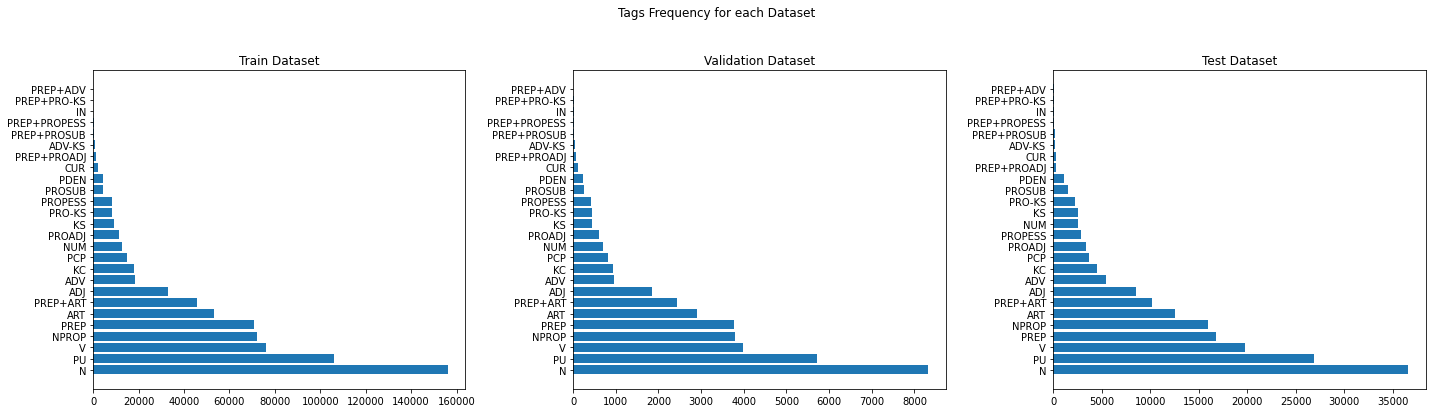

In [5]:
fig, (ax1, ax2, ax3) = plt.subplots(1, 3, figsize=(20, 6))
fig.suptitle('Tags Frequency for each Dataset')

ax1.barh(range(len(train_tags_count)), list(train_tags_count.values()), align='center')
plt.sca(ax1)
plt.yticks(range(len(train_tags_count)), list(train_tags_count.keys()))
plt.title('Train Dataset')

ax2.barh(range(len(val_tags_count)), list(val_tags_count.values()), align='center')
plt.sca(ax2)
plt.yticks(range(len(val_tags_count)), list(val_tags_count.keys()))
plt.title('Validation Dataset')

ax3.barh(range(len(test_tags_count)), list(test_tags_count.values()), align='center')
plt.sca(ax3)
plt.yticks(range(len(test_tags_count)), list(test_tags_count.keys()))
plt.title('Test Dataset')

fig.tight_layout(rect=[0, 0.03, 1, 0.95])
plt.show()

## Padding and Word Embedding

It is common to use word vectors (*word embeddings*) to represent text, including for POS tagging. You can use a Word2Vec (Skip-gram or CBOW), a GloVe, or any other *word embedding* method.

However, for recurrent neural networks, such as LSTM, there is the alternative of representing the words through unique identifiers and applying an Embedding layer as the first trainable layer via *backpropagation*.

Here, we will use these methodologies because they are practical and widely used in the field. For this, the first step is to represent each word with a unique id, which is then done with the **Tokenizer** function of **keras**, as it follows.

In [6]:
# TOKENIZING TEXT
word_tokenizer = Tokenizer()
word_tokenizer.fit_on_texts(train_sentences + val_sentences)

VOCAB_SIZE = len(word_tokenizer.word_index) + 1

train_X = word_tokenizer.texts_to_sequences(train_sentences)
val_X = word_tokenizer.texts_to_sequences(val_sentences)
test_X = word_tokenizer.texts_to_sequences(test_sentences)

# TOKENIZING TAGS
word_tokenizer = Tokenizer()
word_tokenizer.fit_on_texts(train_tags + val_tags)

tags_dict = word_tokenizer.word_index

train_Y = word_tokenizer.texts_to_sequences(train_tags)
val_Y = word_tokenizer.texts_to_sequences(val_tags)
test_Y = word_tokenizer.texts_to_sequences(test_tags)

As Keras can only deal with fixed lengths of sentences, and our sentences have different sizes, we will use the function **pad_sequences** to deal with this problem. We need to define a hyperparameter here called `MAX_LENGHT`. Sentences shorter than this parameter will be appended with words with index 0, while shorter sentences will be truncated up to this limit. Thus, in case of many increments of index 0, it is likely that the model has a higher accuracy than in cases with few increments of 0 and many sentence truncations.

In some cases, it is common to use the size of the largest string. Thus, there would be no truncation of any sentences, but this would add many 0-indexes to the corpus. Finding the optimal point of this "*trade off*" is the task to be done and known as hyperparameter tuning.

A visual analysis that can help us establish the value of `MAX_LENGTH` is to plot the sentence length boxplot, as follows.

c:\Users\phara\anaconda3\lib\site-packages\seaborn\_decorators.py:36: FutureWarning: Pass the following variable as a keyword arg: x. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  warnings.warn(


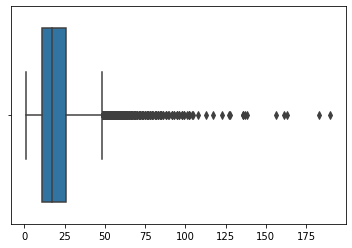

In [7]:
import seaborn as sns

lengths = [len(seq) for seq in train_X]
sns.boxplot(lengths)
plt.show()

The graph above shows that the vast majority of sentences have sizes smaller than 50. Thus, the following values were tested for `MAX_LENGHT`:

- `MAX_LENGTH` = 50, 75, 100, 125, 190 (largest possible - no truncations)

The values presented in this code refer to the best configuration obtained, selected after analyzing the results.

In [8]:
# MAX_LENGTH = len(max(train_X, key=len))
MAX_LENGTH = 75

train_X = pad_sequences(train_X, maxlen=MAX_LENGTH, padding='post', truncating='post')
train_Y = pad_sequences(train_Y, maxlen=MAX_LENGTH, padding='post', truncating='post')

val_X = pad_sequences(val_X, maxlen=MAX_LENGTH, padding='post', truncating='post')
val_Y = pad_sequences(val_Y, maxlen=MAX_LENGTH, padding='post', truncating='post')

test_X = pad_sequences(test_X, maxlen=MAX_LENGTH, padding='post', truncating='post')
test_Y = pad_sequences(test_Y, maxlen=MAX_LENGTH, padding='post', truncating='post')

train_Y = to_categorical(train_Y)
val_Y = to_categorical(val_Y)

## Bidirectional LSTM

Once **padding** is done, we define the model to be used. After a short search, you will find several articles, blogs, etc. using Bidirectional LSTM for the POS-Tagging task. For this reason, we will use this architecture in this work.

As previously mentioned, our model will have an Embedding layer as its first trainable layer, responsible for creating vectors to represent the words. The Embedding layer requires the definition of the hyperparameter related to the number of dimensions of the vectors (called *output_dim*), that is, how many *features* will be used to represent words. In this case, the values tested were:

- `OUTPUT_DIM` = 50, 100, 175, 300.

Next, our model consists of a Bidirectional layer within an LSTM. Unlike a normal LSTM model, which only sees past information, a Bidirectional LSTM also sees future information, thus increasing the model's classification power. Simply put, it's as if the model were reading everything that comes before AND AFTER the word that you want to predict the *tag*.

As a parameter to be tuned in this layer, we only have the size of the LSTM cells, defined by `N_UNITS`. Here, it was tested:

- `N_UNITS` = 32, 64, 128, 256, 512.

Finally, we have a Dense layer with a parameter equal to the number of classes (*tags*), enveloped by a TimeDistributed layer, responsible for applying temporal *slices* to the data. Since this is a *multiclass* classification problem, a *categorical_crossentropy* function is used as *loss*.

The *learning rate* and *batch_size* parameters were also varied.

- `LEARNING_RATE` = 0.0001, 0.0005.
- `BATCH_SIZE` = 32, 64, 128.

In [9]:
from keras.models import Sequential
from keras.layers import Dense, LSTM, InputLayer, Bidirectional, TimeDistributed, Embedding, Activation
from keras.optimizers import Adam

model = Sequential()
model.add(Embedding(input_dim=VOCAB_SIZE, output_dim=100))
model.add(Bidirectional(LSTM(128, return_sequences=True)))
model.add(TimeDistributed(Dense(train_Y.shape[2], activation='softmax')))

model.compile(loss='categorical_crossentropy',
              optimizer=Adam(0.0001),
              metrics=['accuracy'])

# model.summary()
history = model.fit(train_X, train_Y, batch_size=64, epochs=10, validation_data=(val_X, val_Y))

Epoch 1/10
593/593 [==============================] - 111s 184ms/step - loss: 0.9585 - accuracy: 0.7673 - val_loss: 0.6683 - val_accuracy: 0.7908
Epoch 2/10
593/593 [==============================] - 111s 187ms/step - loss: 0.6234 - accuracy: 0.8060 - val_loss: 0.5885 - val_accuracy: 0.8299
Epoch 3/10
593/593 [==============================] - 108s 182ms/step - loss: 0.4976 - accuracy: 0.8561 - val_loss: 0.4067 - val_accuracy: 0.8929
Epoch 4/10
593/593 [==============================] - 110s 185ms/step - loss: 0.3091 - accuracy: 0.9193 - val_loss: 0.2436 - val_accuracy: 0.9340
Epoch 5/10
593/593 [==============================] - 111s 187ms/step - loss: 0.1927 - accuracy: 0.9479 - val_loss: 0.1596 - val_accuracy: 0.9573
Epoch 6/10
593/593 [==============================] - 112s 189ms/step - loss: 0.1306 - accuracy: 0.9661 - val_loss: 0.1171 - val_accuracy: 0.9687
Epoch 7/10
593/593 [==============================] - 112s 189ms/step - loss: 0.0964 - accuracy: 0.9755 - val_loss: 0.0926 -

## Results

The following code provides a graphical view of the training history for accuracy and *loss*. For some cases, depending on the parameters, it was possible to notice an *overfitting* trend for the model. This can be explained by the fact that we used a relatively small corpus and neural networks have great generalization capacity, especially more complex networks. However, with an adequate *adjustment* of the parameters, it was possible to find a configuration for the network capable of performing the Pos Tagging task satisfactorily.

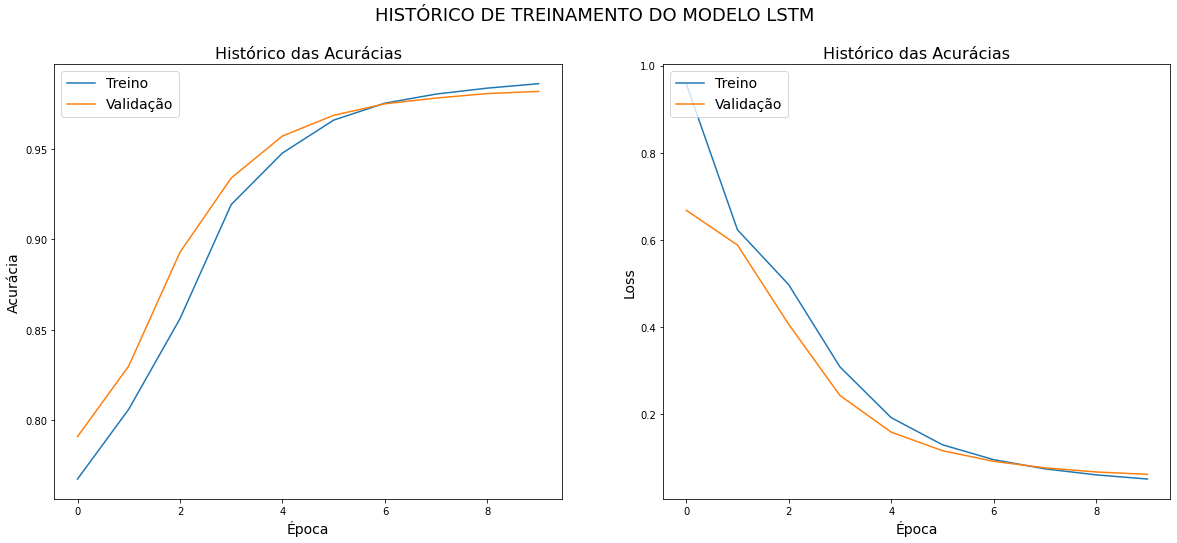

In [10]:
fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(20, 8))
fig.suptitle('HISTÓRICO DE TREINAMENTO DO MODELO LSTM', fontsize=18)

ax1.plot(history.history['accuracy'])
ax1.plot(history.history['val_accuracy'])
plt.sca(ax1)
plt.ylabel('Acurácia', fontsize=14)
plt.xlabel('Época', fontsize=14)
plt.legend(['Treino', 'Validação'], loc='upper left', fontsize=14)
plt.title('Histórico das Acurácias', fontsize=16)

ax2.plot(history.history['loss'])
ax2.plot(history.history['val_loss'])
plt.sca(ax2)
plt.ylabel('Loss', fontsize=14)
plt.xlabel('Época', fontsize=14)
plt.legend(['Treino', 'Validação'], loc='upper left', fontsize=14)
plt.title('Histórico das Acurácias', fontsize=16)

plt.show()

As shown by the representation of the training history above, it's possible to notice that there is no overfitting, since the accuracy and loss function values for training and validation do not differ in large absolute values at the end of training. Thus, we can say that the model has good generalization power. To confirm this statement, let's analyze the values obtained for the test set.

In [11]:
loss, accuracy = model.evaluate(test_X, to_categorical(test_Y), verbose = 1)
print("Loss: {0},\nAccuracy: {1}".format(loss, accuracy))

313/313 [==============================] - 9s 27ms/step - loss: 0.8107 - accuracy: 0.9168
Loss: 0.8107096552848816,
Accuracy: 0.9168292284011841


Using the **evaluate** function, we can see that for the test set our model is right in almost 92% of the cases. However, with the *padding* task we have several sentences with padding "words". Thus, it makes sense to analyze the accuracies by class. For this, we will use the **classification_report** function and generate a heatmap of the confusion matrix with the accuracies per class.

In [12]:
import pandas as pd

preds = model.predict(test_X)
Y_pred = np.argmax(preds, axis=-1)
y_true = np.hstack(test_Y)
y_pred = np.hstack(Y_pred)

tags_list = list(tags_dict.items())
a = ['PADDING'] + [i[0] for i in tags_list]

report = classification_report(y_true, y_pred, target_names=a)
print(report)

313/313 [==============================] - 8s 24ms/step


c:\Users\phara\anaconda3\lib\site-packages\sklearn\metrics\_classification.py:1334: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


              precision    recall  f1-score   support

     PADDING       0.99      1.00      0.99    571096
           n       0.69      0.67      0.68     36451
          pu       0.65      0.65      0.65     26814
           v       0.77      0.72      0.74     19681
       nprop       0.69      0.61      0.64     15898
        prep       0.66      0.67      0.67     16743
         art       0.69      0.74      0.72     12550
    prep+art       0.64      0.67      0.66     10197
         adj       0.61      0.53      0.57      8526
         adv       0.69      0.64      0.66      5434
          kc       0.60      0.60      0.60      4505
         pcp       0.68      0.51      0.59      3634
         num       0.73      0.60      0.66      2536
      proadj       0.63      0.64      0.64      3410
          ks       0.59      0.57      0.58      2533
      pro-ks       0.52      0.54      0.53      2191
     propess       0.72      0.70      0.71      2870
      prosub       0.62    

c:\Users\phara\anaconda3\lib\site-packages\sklearn\metrics\_classification.py:1334: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
c:\Users\phara\anaconda3\lib\site-packages\sklearn\metrics\_classification.py:1334: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


In [13]:
idx = np.where(y_true!=0)
y_true = y_true[idx]
y_pred = y_pred[idx]

tags_list = list(tags_dict.items())
a = ['Padding'] + [i[0] for i in tags_list]

report = classification_report(y_true, y_pred, target_names=a)
print(report)

              precision    recall  f1-score   support

     Padding       0.00      0.00      0.00         0
           n       0.69      0.67      0.68     36451
          pu       0.65      0.65      0.65     26814
           v       0.77      0.72      0.74     19681
       nprop       0.69      0.61      0.64     15898
        prep       0.66      0.67      0.67     16743
         art       0.69      0.74      0.72     12550
    prep+art       0.64      0.67      0.66     10197
         adj       0.61      0.53      0.57      8526
         adv       0.69      0.64      0.66      5434
          kc       0.60      0.60      0.60      4505
         pcp       0.68      0.51      0.59      3634
         num       0.73      0.60      0.66      2536
      proadj       0.63      0.64      0.64      3410
          ks       0.59      0.57      0.58      2533
      pro-ks       0.52      0.54      0.53      2191
     propess       0.72      0.70      0.71      2870
      prosub       0.62    

c:\Users\phara\anaconda3\lib\site-packages\sklearn\metrics\_classification.py:1334: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
c:\Users\phara\anaconda3\lib\site-packages\sklearn\metrics\_classification.py:1334: UndefinedMetricWarning: Recall and F-score are ill-defined and being set to 0.0 in labels with no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
c:\Users\phara\anaconda3\lib\site-packages\sklearn\metrics\_classification.py:1334: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
c:\Users\phara\anaconda3\lib\site-packages\sklearn\metrics\_cla

C:\Users\phara\AppData\Local\Temp\ipykernel_22432\2368111474.py:9: RuntimeWarning: invalid value encountered in longlong_scalars
  foo.iloc[i,j] = foo.iloc[i,j]/somas[i]


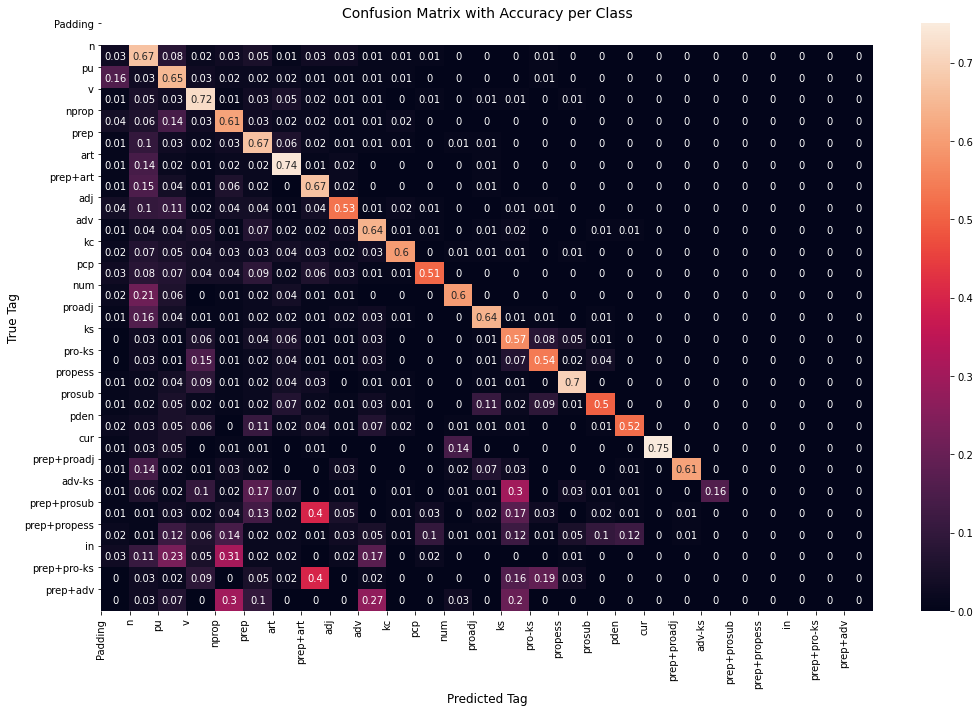

In [14]:
from sklearn.metrics import confusion_matrix

cmat = confusion_matrix(y_true, y_pred)
foo = pd.DataFrame(cmat)
somas = foo.sum(axis=1)

for i in range(len(foo)):
  for j in range(len(foo)):
    foo.iloc[i,j] = foo.iloc[i,j]/somas[i]

fig, ax = plt.subplots(figsize=(15, 10))
ax = sns.heatmap(pd.DataFrame(foo).round(2), annot=True)
plt.sca(ax)
plt.title("Confusion Matrix with Accuracy per Class", fontsize=14)
plt.ylabel('True Tag', fontsize=12)
plt.xlabel('Predicted Tag', fontsize=12)
plt.yticks(range(len(a)), a, rotation=0)
plt.xticks(range(len(a)), a, rotation=90)
plt.tight_layout()
plt.show()

The results obtained show that our model has good classification capacity, especially for word classes that appear more in the corpus. However for the 6 classes with the fewest cases the model has difficulty performing the correct semantic classification.

## Conclusion

The analyzes carried out in this project allow us to conclude that it was possible to train a Bidirectional LSTM model, capable of performing the POS Tagging task satisfactorily, reaching a class-weighted accuracy of around 65% after removing the cases of the 'PAADING' class.

Even with a database of unbalanced classes, the methodology applied in this work proved to be capable of dealing with multiclass classification problems for texts in a quick and simple way.

Special treatments, especially pre-processing, can further increase the accuracies achieved here.